In [29]:
pip install pyvista

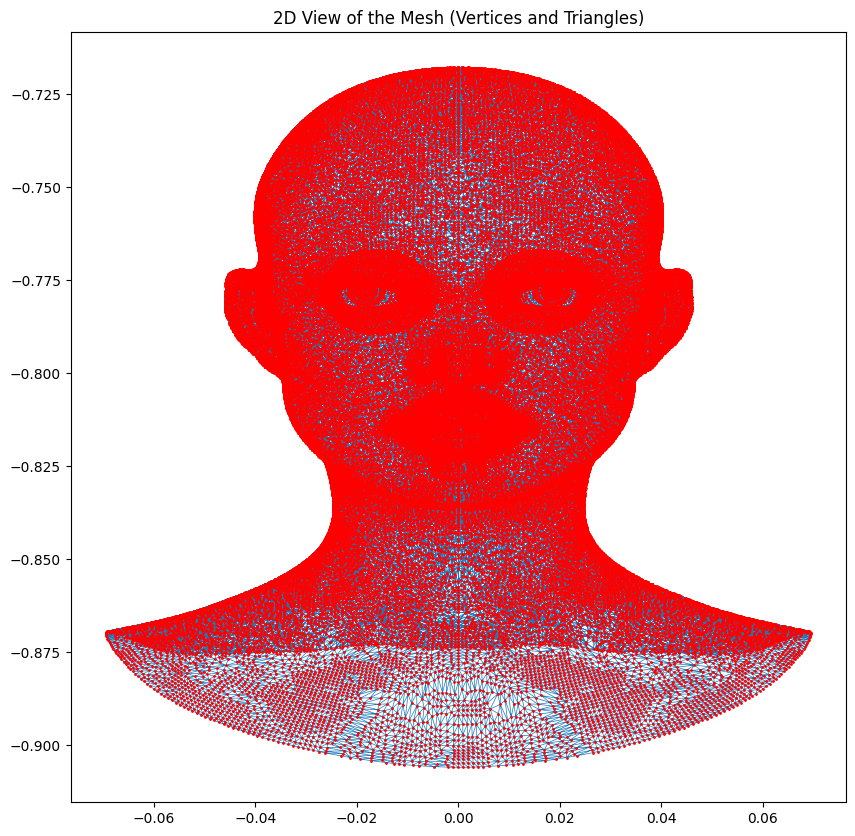

In [30]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the mesh
mesh = o3d.io.read_triangle_mesh("/content/BustBaseMesh_Decimated.obj")

# Convert mesh vertices to NumPy array
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

# Plot the vertices in 2D
plt.figure(figsize=(10, 10))
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, linewidth=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1)
plt.title('2D View of the Mesh (Vertices and Triangles)')
plt.show()


Nombre de faces avant simplification : 149178
Nombre de faces après simplification : 500


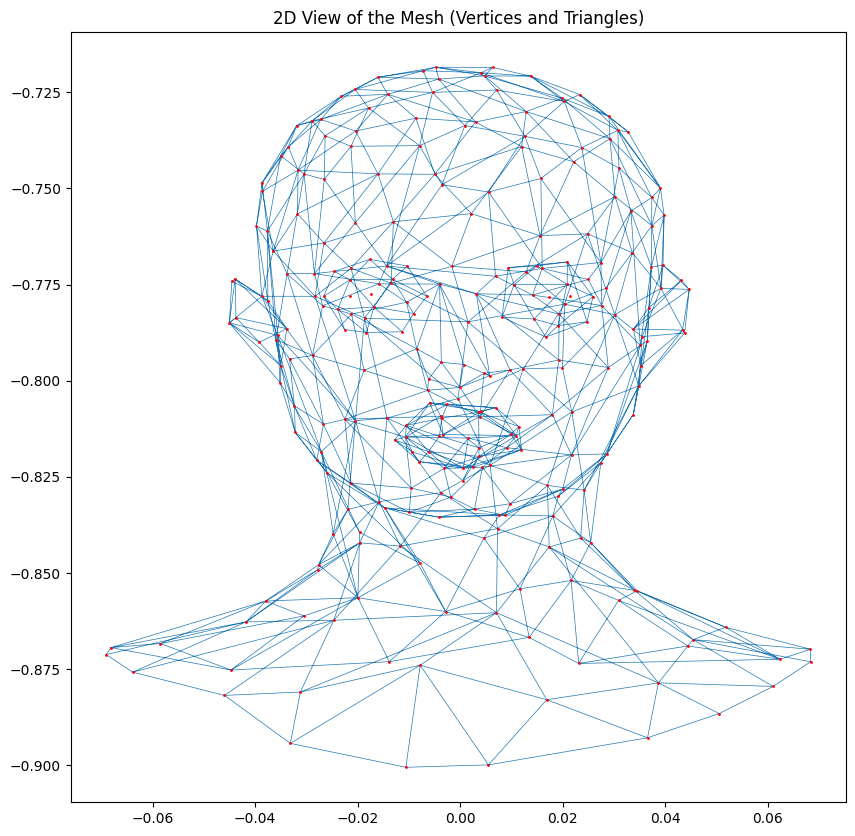

In [64]:
# Paramètres de simplification : nombre cible de faces
nombre_faces_cible = 500

# Utilisation de l’algorithme de simplification
mesh_simplifiee = mesh.simplify_quadric_decimation(target_number_of_triangles=nombre_faces_cible)

# Affichage des statistiques de la nouvelle mesh
print("Nombre de faces avant simplification :", np.asarray(mesh.triangles).shape[0])
print("Nombre de faces après simplification :", np.asarray(mesh_simplifiee.triangles).shape[0])

# Convert mesh vertices to NumPy array
vertices = np.asarray(mesh_simplifiee.vertices)
triangles = np.asarray(mesh_simplifiee.triangles)

# Plot the vertices in 2D
plt.figure(figsize=(10, 10))
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, linewidth=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1)
plt.title('2D View of the Mesh (Vertices and Triangles)')
plt.show()

In [65]:
import numpy as np
import plotly.graph_objects as go
import open3d as o3d

# Load the mesh (replace with your path)
mesh_simplifiee = o3d.io.read_triangle_mesh("BustBaseMesh_Decimated.obj")
mesh_simplifiee.compute_vertex_normals()
vertices = np.asarray(mesh_simplifiee.vertices)
triangles = np.asarray(mesh_simplifiee.triangles)

# Use only the first 500 vertices for the interactive plot
num_vertices_to_use = 500
vertices = vertices[:num_vertices_to_use]

# Filter triangles to ensure they reference the first 500 vertices
valid_triangle_indices = np.all(triangles < num_vertices_to_use, axis=1)
triangles = triangles[valid_triangle_indices]

# Create a 3D mesh plot with both the mesh and the vertices
fig = go.Figure()

# Add the mesh surface
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=triangles[:, 0],
    j=triangles[:, 1],
    k=triangles[:, 2],
    opacity=0.5,
    color='lightblue',
    name='Mesh Surface'
))

# Add the vertices as markers with indices
fig.add_trace(go.Scatter3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    mode='markers+text',
    marker=dict(size=5, color='red', opacity=0.8),
    text=[f'Index: {i}' for i in range(len(vertices))],
    hoverinfo='text'
))

# Update layout for better viewing
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        camera=dict(eye=dict(x=0, y=-1, z=0.5))
    ),
    title='Interactive 3D View of Human Head Mesh with Indexed Points'
)

# Show the figure
fig.show()


In [67]:
# Fonction pour calculer la SRVF d’une courbe (suite de points de la mesh)
def calcul_srvf(curve_points):
    # Calcul des différences entre les points consécutifs
    diffs = np.diff(curve_points, axis=0)
    # Calcul des normes des vecteurs de vitesse
    norms = np.linalg.norm(diffs, axis=1)
    # Normalisation pour obtenir la SRVF
    srvf = diffs / np.sqrt(norms[:, None] + 1e-8)
    return srvf

# Exemple d’utilisation : calcul de la SRVF pour une courbe sur la mesh simplifiée
# Supposons que `points_courbe` représente une suite de points de la mesh
points_courbe = np.asarray(mesh_simplifiee.vertices)[:500]  # On prend une sous-séquence comme exemple
srvf_points = calcul_srvf(points_courbe)

# Affichage de la SRVF pour vérification
print("SRVF calculée pour les points de courbe:", srvf_points)


SRVF calculée pour les points de courbe: [[-2.45263850e-02  3.82454815e-02  7.45542256e-04]
 [-6.39481397e-03 -4.21137422e-02  5.05552839e-03]
 [-6.20052728e-03 -1.73931550e-01  2.82737477e-02]
 ...
 [-2.27454056e-02 -2.94935610e-02 -3.58295394e-03]
 [ 1.57214709e-04  3.13205479e-02  1.31443999e-02]
 [ 1.52619874e-02 -1.70884728e-01 -7.34358446e-03]]


In [68]:
import numpy as np
import plotly.graph_objects as go
from scipy.linalg import svd

# Function to calculate SRVF
def calcul_srvf(curve_points):
    diffs = np.diff(curve_points, axis=0)
    norms = np.linalg.norm(diffs, axis=1)
    srvf = diffs / np.sqrt(norms[:, None] + 1e-8)
    return srvf

# Function to compute optimal rotation using SVD
def optimal_rotation(q1, q2):
    covariance_matrix = np.dot(q1.T, q2)
    U, _, Vt = svd(covariance_matrix)
    rotation = np.dot(U, Vt)
    return rotation

# Function to compute geodesic distance
def geodesic_distance(q1, q2):
    # Flatten the SRVF arrays
    q1_flat = q1.flatten()
    q2_flat = q2.flatten()
    return np.arccos(np.clip(np.dot(q1_flat, q2_flat) / (np.linalg.norm(q1_flat) * np.linalg.norm(q2_flat)), -1.0, 1.0))

# Example usage: compute geodesic distance between two curves
curve1 = np.asarray(mesh_simplifiee.vertices)[:150]  # Example curve
curve2 = np.asarray(mesh_simplifiee.vertices)[150:300]  # Second example curve

# Step 1: Calculate SRVF for both curves
srvf_curve1 = calcul_srvf(curve1)
srvf_curve2 = calcul_srvf(curve2)

# Step 2: Find optimal rotation
rotation_matrix = optimal_rotation(srvf_curve1, srvf_curve2)

# Step 3: Reparameterize the second curve
srvf_curve2_rotated = np.dot(srvf_curve2, rotation_matrix)

# Step 4: Calculate geodesic distance between the two curves
distance = geodesic_distance(srvf_curve1, srvf_curve2_rotated)

print("Geodesic distance between the two curves:", distance)

# Visualization
fig = go.Figure()

# Plot both curves in the mesh
fig.add_trace(go.Scatter3d(x=curve1[:, 0], y=curve1[:, 1], z=curve1[:, 2], mode='lines', name='Curve 1'))
fig.add_trace(go.Scatter3d(x=curve2[:, 0], y=curve2[:, 1], z=curve2[:, 2], mode='lines', name='Curve 2 (rotated)'))

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

fig.show()

Geodesic distance between the two curves: 1.3927217183244753


In [70]:
import numpy as np
import plotly.graph_objects as go

# Assume `mesh_simplifiee` is already defined and contains your mesh vertices

# Indexes of the three reference points
index_left_eye = 159
index_right_eye = 211
index_nose = 100

# Assume `mesh_simplifiee` is your Open3D mesh

# Convert Open3D mesh vertices to a NumPy array
mesh_vertices = np.asarray(mesh_simplifiee.vertices)


# Extract coordinates of the reference points
P1 = mesh_vertices[index_left_eye]
P2 = mesh_vertices[index_right_eye]
P3 = mesh_vertices[index_nose]

# Function to compute geodesic distances to reference points
def compute_geodesic_circle(mesh_vertices, P1, P2, P3, C):
    geodesic_circle_points = []

    for vertex in mesh_vertices:
        dist_P1 = np.linalg.norm(vertex - P1)
        dist_P2 = np.linalg.norm(vertex - P2)
        dist_P3 = np.linalg.norm(vertex - P3)

        if np.abs(dist_P1 + dist_P2 + dist_P3 - C) < 0.01:  # Tolerance
            geodesic_circle_points.append(vertex)

    return np.array(geodesic_circle_points)

# Choose a constant for the sum of distances
C = np.random.uniform(1.0, 3.0)  # Adjust based on your needs

# Calculate geodesic circle points
geodesic_circle_points = compute_geodesic_circle(mesh_vertices, P1, P2, P3, C)

# Visualization
fig = go.Figure()

# Plot the mesh surface
fig.add_trace(go.Mesh3d(x=mesh_vertices[:, 0],
                         y=mesh_vertices[:, 1],
                         z=mesh_vertices[:, 2],
                         opacity=0.5, color='lightblue'))

# Plot the geodesic circle points
if len(geodesic_circle_points) > 0:
    fig.add_trace(go.Scatter3d(x=geodesic_circle_points[:, 0],
                                 y=geodesic_circle_points[:, 1],
                                 z=geodesic_circle_points[:, 2],
                                 mode='markers', marker=dict(size=4, color='red'),
                                 name='Geodesic Circle'))

# Plot the reference points
fig.add_trace(go.Scatter3d(x=[P1[0]], y=[P1[1]], z=[P1[2]],
                             mode='markers', marker=dict(size=8, color='green'),
                             name='Left Eye'))
fig.add_trace(go.Scatter3d(x=[P2[0]], y=[P2[1]], z=[P2[2]],
                             mode='markers', marker=dict(size=8, color='orange'),
                             name='Right Eye'))
fig.add_trace(go.Scatter3d(x=[P3[0]], y=[P3[1]], z=[P3[2]],
                             mode='markers', marker=dict(size=8, color='blue'),
                             name='Nose'))

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Show the plot
fig.show()